In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import warnings
import random
from density_db import density_database
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingRegressor
from sklearn import svm
from sklearn.svm import LinearSVR
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras import initializers
import warnings

In [2]:
#get data
def get_data():
    rawData = density_database('density.db').selectAllErrorsWithParams('Redfield').fetchall()
    return pd.DataFrame(data=rawData, columns=['delta_e', 'J', 'lambda', 'gamma', 'T', 'error'])

In [3]:
#plot
def plot_error(data):
    data.loc[
        (data['delta_e'] == 100.)
        & (data['J'] == 100.)
        & (data['lambda'] == 100.)
        & (data['gamma'] == 100.)
        & (data['T'] == 300.)
    ].plot(kind="scatter", x="delta_e", y="error", logy=True)
    plt.ylim(10**-4,10**-2)

In [19]:
#explore combinations
def correletions():
    tryData = get_data()
    tryData['gamma-lambda'] = tryData['gamma']*tryData['lambda']
    tryData['gamma-delta_e'] = tryData['gamma']*tryData['delta_e']
    tryData['gamma-J'] = tryData['gamma']*tryData['J']
    tryData['lambda-delta_e'] = tryData['lambda']*tryData['delta_e']
    tryData['lambda-J'] = tryData['lambda']*tryData['J']
    tryData['delta_e-J'] = tryData['delta_e']*tryData['J']
    corr_matrix = tryData.corr()
    return corr_matrix['error']
correletions()

delta_e           0.326853
J                 0.495703
lambda            0.325235
gamma             0.225282
T                -0.140881
error             1.000000
gamma-lambda      0.337466
gamma-delta_e     0.369658
gamma-J           0.543054
lambda-delta_e    0.375550
lambda-J          0.584234
delta_e-J         0.664764
Name: error, dtype: float64

In [5]:
def prepare_train_and_test_sets(data):
    modifiedData = data.copy()
    modifiedData['delta_e'] = modifiedData['delta_e']/400
    modifiedData['J'] = modifiedData['J']/400
    modifiedData['lambda'] = modifiedData['lambda']/400
    modifiedData['gamma'] = modifiedData['gamma']/400
    modifiedData['T'] = modifiedData['T']/300
    modifiedData['gamma-lambda'] = modifiedData['gamma']*modifiedData['lambda']
    modifiedData['gamma-delta_e'] = modifiedData['gamma']*modifiedData['delta_e']
    modifiedData['gamma-J'] = modifiedData['gamma']*modifiedData['J']
    modifiedData['lambda-delta_e'] = modifiedData['lambda']*modifiedData['delta_e']
    modifiedData['lambda-J'] = modifiedData['lambda']*modifiedData['J']
    modifiedData['delta_e-J'] = modifiedData['delta_e']*modifiedData['J']
    modifiedData['error'] = np.log(modifiedData['error'])
    return modifiedData

In [6]:
train_set = prepare_train_and_test_sets(get_data())

In [7]:
def mspe(y, y_predicted):
    y = np.exp(y)
    y_predicted = np.exp(y_predicted)
    return 100 * np.sum(np.square((y - y_predicted)/y)) / len(y)

def mape(y, y_predicted):
    y = np.exp(y)
    y_predicted = np.exp(y_predicted)
    return 100 * np.sum(np.abs((y - y_predicted)/y)) / len(y)

def rmse(y, y_predicted):
    y = np.exp(y)
    y_predicted = np.exp(y_predicted)
    return np.sqrt(np.sum(np.square(y - y_predicted)) / len(y))

def visualiseError(data_labels, labels_predicted):
    sort = np.argsort(data_labels)
    plt.plot(range(len(data_labels)), [data_labels[i] for i in sort])
    plt.plot(range(len(labels_predicted)), [labels_predicted[i] for i in sort])
    plt.ylim(-10, 0)
    plt.show()

def trainMethod(methodFactory, train_set, argsForFit):
    data_labels = np.array(train_set["error"].copy())
    data_prepared = np.array(train_set.drop("error", axis=1))
    kfold = KFold(n_splits=3, shuffle=True, random_state=10)
    errors = [];
    errors_train = [];
    part_error = None;
    for train, test in kfold.split(data_prepared, data_labels):
        method = methodFactory()
        method.fit(data_prepared[train], data_labels[train], **argsForFit)
        labels_predicted_train = np.squeeze(method.predict(data_prepared[train]))
        labels_predicted = np.squeeze(method.predict(data_prepared[test]))
        #if len(errors) == 0:
        #    visualiseError(data_labels[test], labels_predicted)
        errors.append(rmse(data_labels[test], labels_predicted))
        errors_train.append(rmse(data_labels[train], labels_predicted_train))
    print('Test Error: %.2e' % (sum(errors)/len(errors)))
    print('Train Error: %.2e' % (sum(errors_train)/len(errors_train)))
    return (sum(errors)/len(errors), sum(errors_train)/len(errors_train))

In [8]:
def createLinearRegressor():
    return LinearRegression()

def createRandomForestRegressor():
    return RandomForestRegressor(n_estimators=50, max_leaf_nodes = 100, max_depth = 5)

def createSupportVectorMachinesRegressor():
    return SVR(kernel = 'rbf', gamma = 'scale', epsilon = 0.1, C = 1)

def createNearestNeighborsRegressor():
    return KNeighborsRegressor(n_neighbors=5, weights='uniform')

def createLinearLassoRegressor():
    return Lasso(alpha = 0.01)

def createLinearRidgeRegressor():
    return Ridge()

def createDecisionTreeRegressor():
    return DecisionTreeRegressor(max_leaf_nodes = 100, max_depth = 5)

def createGaussianProcessRegressor():
    kernel = DotProduct() + WhiteKernel()
    return GaussianProcessRegressor(kernel=kernel,random_state=0)

def createVotingRegressor():
    svr = createSupportVectorMachinesRegressor()
    for_reg = createRandomForestRegressor()
    k_neigh = createNearestNeighborsRegressor()
    linear = createLinearRegressor()
    return VotingRegressor([('a', svr), ('b', for_reg), ('c', k_neigh), ('d', linear)])

def createNeuralNetwork():
    method = keras.Sequential([
            keras.layers.Dense(11, activation = 'elu', input_shape=(11,)),
            keras.layers.Dense(11, activation = 'elu'),
            keras.layers.Dense(1)
        ])
    optimizer = optimizers.Adam(learning_rate=0.1)
    method.compile(optimizer=optimizer, loss='mean_squared_error')
    return method

In [9]:
allErrors = []
allLabels = ['Linear', 'Linear Lasso', 'Linear Ridge', 'Random Forest', 'Decision Tree', 'K Nearest Neighbors', 'Support Vector Machines', 'Voting Regressor', 'Gaussian Process', 'Neural Network']
print('Linear')
error = trainMethod(createLinearRegressor, train_set, {})
allErrors.append(error)
print()
print('Linear Lasso')
error = trainMethod(createLinearLassoRegressor, train_set, {})
allErrors.append(error)
print()
print('Linear Ridge')
error = trainMethod(createLinearRidgeRegressor, train_set, {})
allErrors.append(error)
print()
print('Random Forest')
error = trainMethod(createRandomForestRegressor, train_set, {})
allErrors.append(error)
print()
print('Decision Tree')
error = trainMethod(createDecisionTreeRegressor, train_set, {})
allErrors.append(error)
print()
print('K Nearest Neighbors')
error = trainMethod(createNearestNeighborsRegressor, train_set, {})
allErrors.append(error)
print()
print('Support Vector Machines')
error = trainMethod(createSupportVectorMachinesRegressor, train_set, {})
allErrors.append(error)
print()
print('Voting Regressor')
error = trainMethod(createVotingRegressor, train_set, {})
allErrors.append(error)
print()
print('Gaussian Process')
error = trainMethod(createGaussianProcessRegressor, train_set, {})
allErrors.append(error)
print()
print('Neural Network')
error = trainMethod(createNeuralNetwork, train_set, {'batch_size': 200, 'epochs': 200, 'validation_split': 0, 'verbose': 0})
allErrors.append(error)

Linear
Test Error: 9.75e-04
Train Error: 9.57e-04

Linear Lasso
Test Error: 1.08e-03
Train Error: 1.05e-03

Linear Ridge
Test Error: 9.92e-04
Train Error: 9.67e-04

Random Forest
Test Error: 8.36e-04
Train Error: 6.56e-04

Decision Tree
Test Error: 9.77e-04
Train Error: 7.65e-04

K Nearest Neighbors
Test Error: 9.11e-04
Train Error: 7.68e-04

Support Vector Machines
Test Error: 7.82e-04
Train Error: 6.95e-04

Voting Regressor
Test Error: 7.96e-04
Train Error: 7.22e-04

Gaussian Process
Test Error: 1.10e-03
Train Error: 1.03e-03

Neural Network
Test Error: 8.11e-04
Train Error: 7.99e-04


(array([0.    , 0.0002, 0.0004, 0.0006, 0.0008, 0.001 , 0.0012]),
 <a list of 7 Text xticklabel objects>)

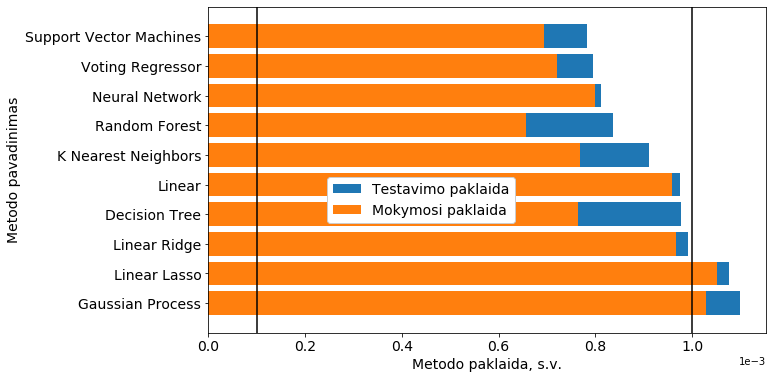

In [11]:
allErrors
testErrors = list(zip(*allErrors))[0]
trainErrors = list(zip(*allErrors))[1]
sort = list(reversed(np.argsort(testErrors)))
plt.figure(figsize=(10, 6))
plt.plot([10**-3, 10**-3], [-10, 15], c = 'k')
plt.plot([10**-4, 10**-4], [-10, 15], c = 'k')
a = plt.barh([allLabels[i] for i in sort], [testErrors[i] for i in sort])
b = plt.barh([allLabels[i] for i in sort], [trainErrors[i] for i in sort])
plt.legend([a, b], ['Testavimo paklaida', 'Mokymosi paklaida'], bbox_to_anchor=(0.2, 0, 0, 0.5), framealpha = 1, fontsize=14)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.ylim(-1, 10)
plt.xlabel('Metodo paklaida, s.v.', fontsize=14)
plt.ylabel('Metodo pavadinimas', fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)